# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
n_records = len(data)

n_greater_50k = len(data[data["income"] == ">50K"])

n_at_most_50k = len(data[data["income"] == "<=50K"])

greater_percent = round(((n_greater_50k / n_records) * 100), 3)

# Print the results
print(f"Total number of records: {n_records:,}")
print(f"Individuals making more than $50,000: {n_greater_50k:,}")
print(f"Individuals making at most $50,000: {n_at_most_50k:,}")
print(f"Percentage of individuals making more than $50,000: {greater_percent}%")

Total number of records: 45,222
Individuals making more than $50,000: 11,208
Individuals making at most $50,000: 34,014
Percentage of individuals making more than $50,000: 24.784%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

C:\Users\cnlee\Udacity\p1_charityml\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


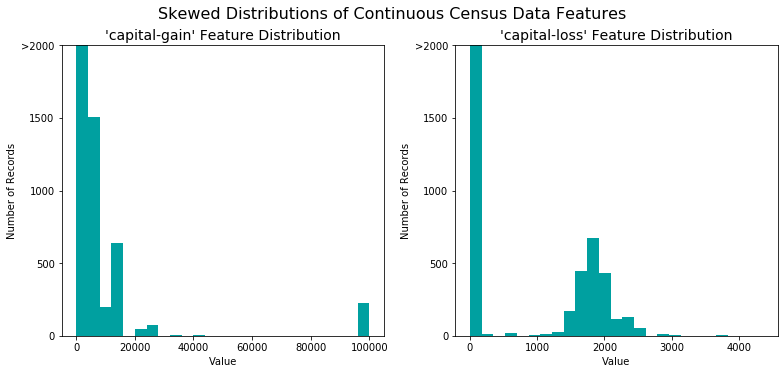

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

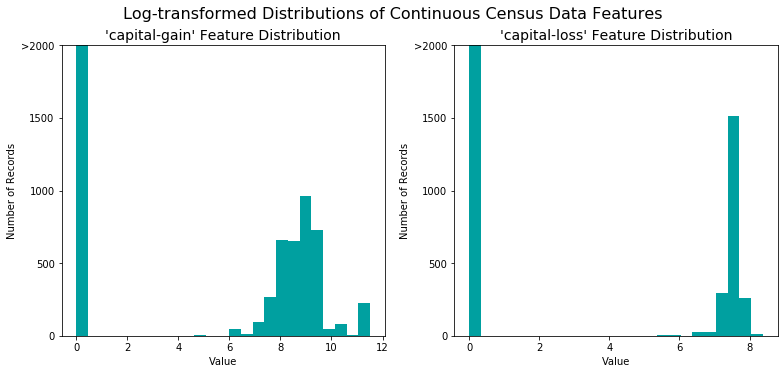

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
features_final = pd.get_dummies(features_log_minmax_transform)

income = income_raw.map({"<=50K":0, ">50K":1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print(f"{len(encoded)} total features after one-hot encoding.")

# Uncomment the following line to see the encoded feature names
#print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print(f"Training set has {X_train.shape[0]:,} samples.")
print(f"Testing set has {X_test.shape[0]:,} samples.")

Training set has 36,177 samples.
Testing set has 9,045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.


In [8]:
"""
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
"""

TP = income.sum()
FP = income.count() - TP

TN = 0.0
FN = 0.0


# Calculate accuracy, precision and recall
accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))

# Print the results 
print(f"Naive Predictor: [Accuracy score: {accuracy:.4f}, F-score: {fscore:.4f}]")

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

### Answer: 

#### 1. Random Forest
1. Describe one real-world application in industry where the model can be applied. <br>
<t> • Random Forest has been used for Wikipedia article quality assessment<sup>[RF1]</sup>.
2. What are the strengths of the model; when does it perform well?<br>
<t> • Random Forest performs well on large datasets<sup>[RF2]</sup>.
3. What are the weaknesses of the model; when does it perform poorly?<br>
<t> • Random Forest averages multiple decision tree models which are known to be susceptible to overfitting<sup>[RF3]</sup>.
4. What makes this model a good candidate for the problem, given what you know about the data? <br>
<t> • This algorithm produces a human-interpretable decision tree<sup>[RF3]</sup> which can useful for CharityML after the model is in production<sup>[RF4]</sup>.

#### 2. Gradient Boosting
1. Describe one real-world application in industry where the model can be applied. <br>
<t> • Yahoo uses Gradient Boosting in it's ranking engine<sup>[GB1]</sup>.
2. What are the strengths of the model; when does it perform well? <br>
<t> • Gradient boosting generalizes well through the regularization parameters<sup>[GB2]</sup>. 
3. What are the weaknesses of the model; when does it perform poorly? <br>
<t> • Depending on the algorithm's hyper-parameters training can be slower than other ensemble methods<sup>[GB3]</sup>.
4. What makes this model a good candidate for the problem, given what you know about the data? <br>
<t> • This algorithm produces a human-interpretable decision tree<sup>[GB3]</sup> which can useful for CharityML after the model is in production<sup>[GB4]</sup>.

#### 3. Support Vector Classifier (SVC)
1. Describe one real-world application in industry where the model can be applied. <br>
<t> • SVCs are used to classify various applications including image classification and protein classification<sup>[SVC1]</sup>
2. What are the strengths of the model; when does it perform well? <br>
<t> • SVCs are capable of mapping higher-dimensional feature spaces using the kernel trick<sup>[SVC2]</sup>.
3. What are the weaknesses of the model; when does it perform poorly? <br>
<t> • SVC does not scale well with dataset size as training time grows quadratically<sup>[SVC1]</sup>.
4. What makes this model a good candidate for the problem, given what you know about the data? <br>
<t> • As a classifier, SVCs can produce useful results on higher-dimensional/many-featured datasets<sup>[SVC1]</sup>.

#### References
RF1: https://en.wikipedia.org/wiki/Random_forest#RF_in_scientific_works <br>
RF2: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm <br>
RF3: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier <br>
RF4: https://www.kdnuggets.com/2018/12/machine-learning-explainability-interpretability-ai.html <br>

GB1: https://en.wikipedia.org/wiki/Gradient_boosting#Usage <br>
GB2: https://en.wikipedia.org/wiki/Gradient_boosting#Regularization <br>
GB3: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html <br>
GB4: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier <br>
GB5: https://www.kdnuggets.com/2018/12/machine-learning-explainability-interpretability-ai.html <br>

SVC1: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html <br>
SVC2: https://en.wikipedia.org/wiki/Support-vector_machine <br>

[RF1]: https://en.wikipedia.org/wiki/Random_forest#RF_in_scientific_works
[RF2]: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm
[RF3]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
[RF4]: https://www.kdnuggets.com/2018/12/machine-learning-explainability-interpretability-ai.html

[GB1]: https://en.wikipedia.org/wiki/Gradient_boosting#Usage
[GB2]: https://en.wikipedia.org/wiki/Gradient_boosting#Regularization
[GB3]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
[GB4]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
[GB5]: https://www.kdnuggets.com/2018/12/machine-learning-explainability-interpretability-ai.html

[SVC1]: https://en.wikipedia.org/wiki/Support-vector_machine#applications
[SVC2]: https://en.wikipedia.org/wiki/Support-vector_machine

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' 
    #                  using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = (end - start)
    
    
    # Get the predictions on the test set(X_test),
    #  then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    # Compute accuracy on the first 300 training samples which is y_train[:300]       
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    
    # Compute accuracy on test set using accuracy_score()   
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
    
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print(f"{learner.__class__.__name__} trained on {sample_size:,} samples.")
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

---------------------------------------
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3,617 samples.
RandomForestClassifier trained on 36,177 samples.
---------------------------------------
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3,617 samples.
GradientBoostingClassifier trained on 36,177 samples.
---------------------------------------
SVC trained on 361 samples.
SVC trained on 3,617 samples.
SVC trained on 36,177 samples.
---------------------------------------


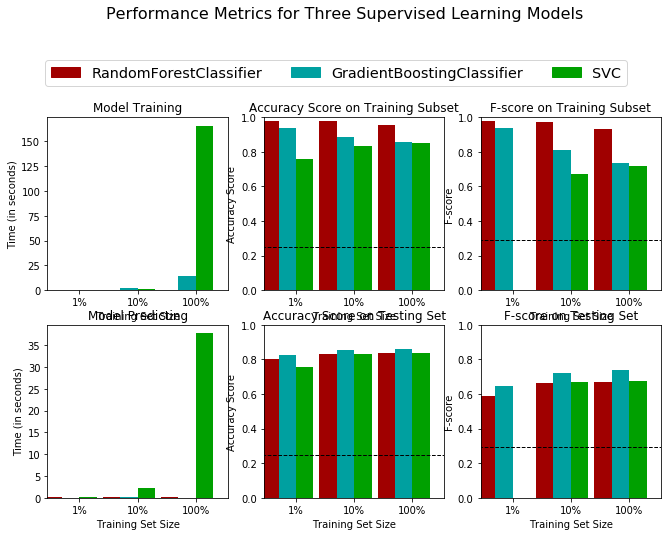

In [10]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

clf_A = RandomForestClassifier(n_jobs=-1,random_state=0)
clf_B = GradientBoostingClassifier(random_state=0)
clf_C = SVC(random_state=0)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.10)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
print("---------------------------------------")
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
    print("---------------------------------------")
    
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

### Answer: 

Based on the initial findings from the base algorithms, the Graident Boosting classifier will be selected to build the model. The gradient boosting algorithm has a number of advantages for this problem:

1. This algorithm produced a model with both the highest accuracy and highest F-score using the full training set.

| Full Training  | Gradient Boosting | Random Forest  | SVC     |
| :------------: | :---------------: | :------------: | :-----: |
| Accuracy Score |  0.8630           |    0.8377      |  0.8371 |
| F-score        |  0.7395           |    0.6716      |  0.6745 |

2. The training time was the longest of the three algorithms evaluated. However, once the model was trained it was nearly 6x faster during the prediction time compared to the next fastest algorithm. For this context, the prediction time will be most relevant for our production tools.

| Full Training   | Gradient Boosting | Random Forest  | SVC               |
| :-------------: | :---------------: | :------------: | :---------------: |
| Training Time   |  10.9492 seconds  | 0.4852 seconds |  119.8949 seconds |
| Prediction Time |  0.0382 seconds   | 0.2257 seconds |  20.4555 seconds  |


3. The gradient boosting algorithm produces a decision tree that can be interpreted by non-technical team members in the CharityML organization<sup>[1]</sup>. The algorithm is also resistant to outliers, i.e. generalizes well, through its regularization parameters<sup>[2]</sup>. This will be useful when the organization introduces new donors to the trained model. 

1: https://www.kdnuggets.com/2018/12/machine-learning-explainability-interpretability-ai.html <br>
2: https://en.wikipedia.org/wiki/Gradient_boosting#Regularization

[1]: https://www.kdnuggets.com/2018/12/machine-learning-explainability-interpretability-ai.html
[2]: https://en.wikipedia.org/wiki/Gradient_boosting#Regularization

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

### Answer: 
After training the gradient boosting classifier, the final product will enable CharityML to quickly identify the most likely donor candidates. Gradient boosting is a part of a class of algorithms known as ensemble methods<sup>[1]</sup>. This model, similar to other ensemble methods, rely upon multiple iterations of the model to find the "best" model<sup>[2]</sup>. "Best" is usually defined by the model that produces the most correct answers. The underlying algorithm will be adjusted to this use case by tweaking various parameters<sup>[2]</sup>. After the training process, a decision-tree-like set of features<sup>[3]</sup> such as age, education, etc. from the original census data  will be used to identify new potential donors. These features will be available to CharityML for review and use for other advertising, marketing and outreach and efforts.


1: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble <br>
2: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html <br>
3: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_

[1]: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
[2]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
[3]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scorer = make_scorer(fbeta_score, beta=0.5)

clf = GradientBoostingClassifier(random_state=0)

params = {"loss": ["deviance","exponential"],
        "learning_rate": [1.0e-6, 1.0e-3, 0.1],
        "n_estimators": [10, 100],
        "max_depth": [1, 3, 6],
        "warm_start": [False, True],
}

grid_obj = GridSearchCV(clf, params, scorer, n_jobs=-1, verbose=1)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 13.3min finished


Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8704
Final F-score on the testing data: 0.7515


In [12]:
print(f"{best_clf}")

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.8630           |  0.8704         |
| F-score        |  0.7395           |  0.7515         |


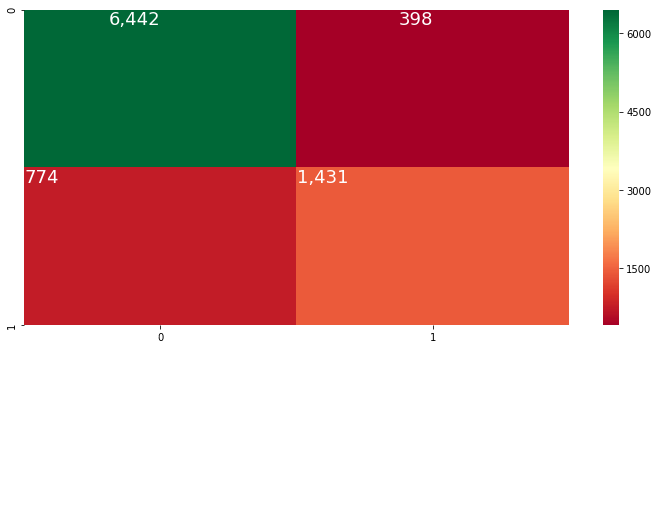

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

best_pred = best_clf.predict(X_test)
data = confusion_matrix(y_test, best_pred)

fig, ax = plt.subplots(1,1,figsize=(10,8))


sns.heatmap(data=data,
            annot=True,
            fmt=",",
            cmap="RdYlGn", 
            ax=ax,
            annot_kws={"fontsize":"18","ha":"right","va":"top"})


for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        #plt.text(x, y+1, '%d' % data[data.shape[0] - y - 1, x],
        plt.text(x, y+1, f"{data[data.shape[0] - y - 1, x]:,}",
         ha="left",va="top", color="w", fontsize="18")

fig.tight_layout()

### Answer: 
The optimized model produces an accuracy of 0.8704 and an F-Score of 0.7515 which is a 69 bps and 100 bps, respectively, improvement over the unoptimized model. These results are far more predictive than the naive predictor (Naive Predictor: Accuracy score: 0.2478, F-score: 0.2917). We can also directly examine the confusion matrix to confirm the accuracy and F-Score metrics.

|                |                |
| :------------: | :------------: |
| True Positive  | False Positive |
| False Negative | True Negative  |


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

### Answer:

Feature Relevance Hypothesis:
1. education
2. age
3. occupation
4. sex
5. marital-status

These features are ranked based on personal experience / bias. One could expect that older, highly-educated individuals in a high-earning field will correlate well to higher income. Sex is a personal bias based on reading previous articles and studies citing an income gap between male and females<sup>[1],[2],[3]</sup>. The Marital-status feature ranking is also a priori; poverty rates in the US are lowest for married couples<sup>[4]</sup>.

1: https://www.weforum.org/agenda/2015/10/why-gender-and-income-inequality-are-linked/ <br>
2: https://www.worldatlas.com/articles/income-inequality-by-race-and-gender-in-the-u-s.html <br>
3: https://ourworldindata.org/six-facts-pay-gap <br>
4: https://www.ssa.gov/policy/docs/population-profiles/marital-status-poverty.html <br>

[1]: https://www.weforum.org/agenda/2015/10/why-gender-and-income-inequality-are-linked/
[2]: https://www.worldatlas.com/articles/income-inequality-by-race-and-gender-in-the-u-s.html
[3]: https://ourworldindata.org/six-facts-pay-gap
[4]: https://www.ssa.gov/policy/docs/population-profiles/marital-status-poverty.html

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

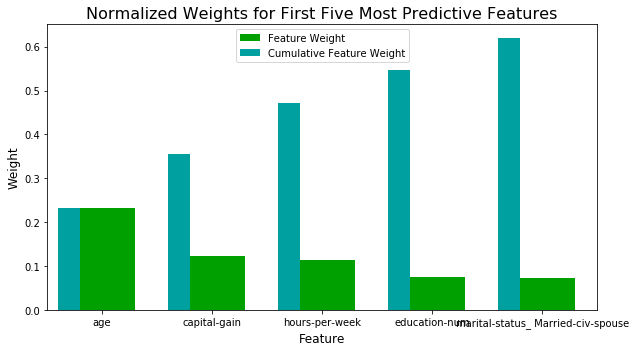

age: 23.25%

capital-gain: 12.35%

hours-per-week: 11.48%

education-num: 7.57%

marital-status_ Married-civ-spouse: 7.32%



In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X_train, y_train)

importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)


indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]

for idx, feature in enumerate(columns):
    print(f"{feature}: {(values[idx] * 100):.2f}%\n")

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

### Answer: 

My original hypothesis:
1. education
2. age
3. occupation
4. sex
5. marital-status

Experiment Feature Importance:
1. age: 23.25%
2. captial-gain: 12.35%
3. hours-per-week: 11.48%
4. education-num: 7.57%
5. marital-status_ Married-civ-spouse: 7.32%


My hypothesis and the model had three similar features {**age, marital-status**, **education/education-num**}. The visualization confirms a portion of my initial hypothesis. However, the **capital-gain** and **hours-per-week** features are sensible. 

Capital-gains only applies to individuals investing in markets - which tends to be wealthier individuals and institutions.
It is also sensible that when individuals work longer hours her or his income is higher.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8704
F-score on testing data: 0.7515

Final Model trained on reduced data
------
Accuracy on testing data: 0.8495
F-score on testing data: 0.7024


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

Accuracy is reduced by 209 bps, or 2.4%, and the F-score is reduced by 491 bps, or 6.5%. Because the F-score is a useful tool to measure false positives the reduced-feature model _could_ be concerning if CharityML has significant costs associated with misidentifying lower income individuals. However, because this is a lead-scoring tool for the organization, false positives may still yield donations. The lower complexity and faster training time of the reduced-feature model could be "good-enough" for CharityML's use case.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.